### 함수 정의

In [2]:
import json
import numpy as np
import cv2

def json2label(path):
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
    labels = [shape["label"] for shape in data["shapes"]]
    points = [np.array(shape["points"]).astype(np.int32) for shape in data["shapes"]]
    return labels, points

def get_poly_box_wh(poly_box): # (4,2)
    lt, rt, rb, lb = poly_box
    w = int((np.linalg.norm(lt - rt) + np.linalg.norm(lb - rb)) // 2)
    h = int((np.linalg.norm(lt - lb) + np.linalg.norm(rt - rb)) // 2)
    return w, h

def crop_obj_in_bg(bg_img, poly, w, h):
    poly = poly.astype(np.float32)
    pos = np.float32([[0,0], [w,0], [w,h], [0,h]])
    M = cv2.getPerspectiveTransform(poly, pos)
    obj_img = cv2.warpPerspective(bg_img, M, (w, h))
    return obj_img, M

### Test Crop

In [72]:
img_path = "./raw_data/image/239.jpg"
label_path = "./raw_data/label/239.json"

labels, polys = json2label(label_path)
labels

['1.08.21', '1.08.', '8.21']

In [73]:
label = labels[0]
aa = len(label) - label.count('.') - label.count(':')*0.5

In [74]:
img = cv2.imread(img_path)
w, h = get_poly_box_wh(polys[0])
w = round(0.6 * h * aa)

new_img, _ = crop_obj_in_bg(img, polys[0], w, h)

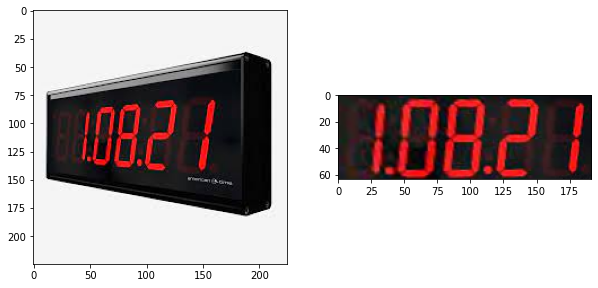

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(img[:,:,::-1])
plt.subplot(122)
plt.imshow(new_img[:,:,::-1])

### Make crop img

In [86]:
from tqdm import tqdm
from glob import glob
import os

if not os.path.isdir("./crop_data"): os.mkdir("./crop_data")
if not os.path.isdir("./crop_data/image"): os.mkdir("./crop_data/image")
if not os.path.isdir("./crop_data/label"): os.mkdir("./crop_data/label")

img_paths = sorted(glob("./raw_data/image/*.jpg"))
label_paths = sorted(glob("./raw_data/label/*.json"))

cnt = 0

for img_path, label_path in tqdm(zip(img_paths, label_paths), total=len(img_paths)):
    img = cv2.imread(img_path)
    labels, polys = json2label(label_path)
    
    for label, poly in zip(labels, polys):
        factor = len(label) - label.count('.') - label.count(':')*0.5
        _, h = get_poly_box_wh(poly)
        w = round(0.6 * h * factor)
        
        crop_img, _ = crop_obj_in_bg(img, poly, w, h)
        
        # save data
        cv2.imwrite(f"./crop_data/image/{cnt:04d}.jpg", crop_img)
        with open(f"./crop_data/label/{cnt:04d}.txt", 'w') as f:
            f.write(label)
            
        cnt += 1

100%|██████████| 462/462 [00:02<00:00, 163.31it/s]
